In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from keras.models import load_model
from keras.metrics import Precision, Recall
from keras.callbacks import CSVLogger, EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

!pip install transformers
!pip install sentencepiece
from transformers import XLNetTokenizer, TFXLNetModel, PreTrainedTokenizerBase


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 51.7 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [2]:
import nltk
import matplotlib.pyplot as plt

from re import sub
from pandas import DataFrame
from tabulate import tabulate
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from typing import Union, List, Tuple
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pandas.io.parsers import TextFileReader
from collections import Counter

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download('punkt')
__STOPWORDS = stopwords.words("english")
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()


def process_data(text: str, do_stemming: bool = False, do_lemmas: bool = False, do_lowercase: bool = False) -> str:
    """
    @param text: The text to process. It will remove the money amounts, retweets, links,
                 hashtags, punctuation and it will lowercase all the words
    @param do_stemming: Steam words to have less in vocabulary if set to true
    @param do_lowercase: Lowercase input text if set to true
    @param do_lemmas: Lemmatize word to be at a dictionary representation if true
    @return: The new processed text as a list of words
    """
    text = sub(r" +", " ", text)
    text = sub(r"\S@\S\s?", "", text)
    text = sub(r"[0-9]+(?:.[0-9]+){3}", "", text)
    text = sub(r"\$\w*", "", text)
    text = sub(r"(RT)+", "", text)
    text = sub(r"(lt)+", "", text)
    text = sub(r"(gt)+", "", text)
    text = sub(r"@[a-zA-Z0-9\_]+", "", text)
    text = sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", text)
    text = sub(r"#", "", text)
    text = sub(r"\d+", "", text)
    text = sub("[^A-Za-z0-9]+", " ", text)  # also removes special characters since they are not alphanumeric
    if do_lowercase:
        text = text.lower()

    # tokenized_data = __TOKENIZER.tokenize(text)
    tokenized_data = word_tokenize(text)
    processed_data = []

    for word in tokenized_data:
        if word not in __STOPWORDS and word not in punctuation:
            if do_stemming and not do_lemmas:
                word = STEMMER.stem(word)
            elif do_lemmas and not do_stemming:
                word = LEMMATIZER.lemmatize(word)
            elif do_lemmas and do_stemming:
                raise ValueError(
                    f"Can't do both lemmatizing and stemming. Values for do_lemmas={do_lemmas} "
                    f"and do_stemming={do_stemming} cannot be true for both."
                )
            processed_data.append(word)

    return " ".join(processed_data)


def plot_train_data(csv_data: Union[TextFileReader, DataFrame], train_metric: str, validation_metric: str) -> None:
    plt.figure()
    plt.plot(csv_data[train_metric], color="blueviolet")
    plt.plot(csv_data[validation_metric], color="green")
    plt.title(f"{train_metric.capitalize()} over epochs")
    plt.legend(["train", "validation"])
    plt.xlabel("epoch")
    plt.ylabel(train_metric)
    plt.grid(visible=True)


def display_train_report_and_f1_score(csv_data: Union[TextFileReader, DataFrame]) -> None:
    headers = ["epoch", "accuracy", "loss", "precision", "recall"]
    train_rep = csv_data[csv_data["epoch"] == len(csv_data) - 1][headers]
    precision = train_rep["precision"].iloc[0]
    recall = train_rep["recall"].iloc[0]
    f1_score = 2 * precision * recall / (precision + recall)
    train_rep["f1_score"] = f1_score
    rep_data = train_rep.values.tolist()
    print('\033[92m')
    print("╒═════════════════╕")
    print("│ Training Report │")
    print(tabulate(rep_data, headers=[header.capitalize() for header in headers] + ["F1 Score"], tablefmt="fancy_grid"))


def display_readable_time(start_time: float, end_time: float) -> None:
    minutes = (end_time - start_time) / 60
    ss = (end_time - start_time) % 60
    hh = minutes / 60
    mm = minutes % 60
    print('\033[94m')
    print(f"Training time: %02d:%02d:%02d | {round(end_time - start_time, 2)} seconds" % (hh, mm, ss))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir train_local
# !wget /content/drive/MyDrive/dataset/abusive-language/vidgen-wassem-davidson-founta-zampieri.zip
!unzip /content/drive/MyDrive/dataset/abusive-language/vidgen-wassem-davidson-founta-zampieri.zip -d /content/train_local

Archive:  /content/drive/MyDrive/dataset/abusive-language/vidgen-wassem-davidson-founta-zampieri.zip
  inflating: /content/train_local/dynamically-hate-vidgen/Dynamically Generated Hate Dataset - annotation guidelines.pdf  
  inflating: /content/train_local/dynamically-hate-vidgen/Dynamically_Generated_Hate_Dataset_v0.2.2.csv  
  inflating: /content/train_local/dynamically-hate-vidgen/Dynamically_Generated_Hate_Dataset_v0.2.3.csv  
  inflating: /content/train_local/dynamically-hate-vidgen/README.md  
  inflating: /content/train_local/hateful-wassem/README.md  
  inflating: /content/train_local/hateful-wassem/wassem_hovy_naacl.tsv  
   creating: /content/train_local/hatespeech-davidson/data/
  inflating: /content/train_local/hatespeech-davidson/data/labeled_data.csv  
  inflating: /content/train_local/hatespeech-davidson/data/labeled_data.p  
  inflating: /content/train_local/hatespeech-davidson/data/readme.md  
  inflating: /content/train_local/hatespeech-davidson/LICENSE  
  inflating

In [5]:
# TODO: Update these with the google stuff
WASSEM_DIR = os.path.join("/content/train_local", "hateful-wassem")
TRAIN_SET_PATH = os.path.join(WASSEM_DIR, "wassem_hovy_naacl.tsv")
WASSEM_MODEL_LOGS_PATH = os.path.join("/content/drive/MyDrive/nlp-models/abusive-language/logs", "wassem")
WASSEM_MODEL_PATH = os.path.join("/content/drive/MyDrive/nlp-models/abusive-language/models", "wassem")


MODEL_FILE_NAME = "xlnet_large_wassem"
XLNET_TYPE = "xlnet-large-cased"  # xlnet-large-cased | xlnet-base-cased

# Clean: 41462 | No lowercase: 18973 | Lowercase: 15226 | Lowercase & Stemming: 10845 | Lowercase & Lemmas: 13671
VOCAB_SIZE = 13671

# Clean: 34 | No lowercase: 25 | Lowercase: 24 | Lowercase & Stemming: 24 | Lowercase & Lemmas: 24
MAX_PADDING_LENGTH = 24

LEARNING_RATE = 2e-5  # 0.0001 | 2e-5
EPOCHS = 150
BATCH_SIZE = 32


In [6]:

def encode_tweet(tweet: str, xlnet_tokenizer: PreTrainedTokenizerBase):
    return xlnet_tokenizer.encode_plus(
        # tweet,
        process_data(tweet, do_stemming=False, do_lemmas=False, do_lowercase=True),
        add_special_tokens=True,
        max_length=MAX_PADDING_LENGTH,
        truncation=True,
        padding="max_length",
        return_attention_mask=True
    )


def encode_tweets(tweets_text: list, tweets_labels, xlnet_tokenizer: PreTrainedTokenizerBase):
    if tweets_labels is not None:
        assert len(tweets_text) == len(tweets_labels), f"Features and labels must have the same lengths. " \
                                                       f"Your input ({len(tweets_text)}, {len(tweets_labels)})"

    input_ids = []
    token_type_ids = []
    attention_masks = []

    for tweet in tweets_text:
        tweet_for_xlnet = encode_tweet(tweet, xlnet_tokenizer)
        input_ids.append(tweet_for_xlnet["input_ids"])
        token_type_ids.append(tweet_for_xlnet["token_type_ids"])
        attention_masks.append(tweet_for_xlnet["attention_mask"])

    if tweets_labels is not None:
        assert len(input_ids) == len(token_type_ids) == len(attention_masks) == len(tweets_labels), \
            "Arrays must have the same length."
        return np.array(input_ids), np.array(token_type_ids), np.array(attention_masks), np.array(tweets_labels)

    return np.array(input_ids), np.array(token_type_ids), np.array(attention_masks)


def generate_xlnet_dict(input_ids, token_type_ids, attention_mask) -> dict:
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask
    }


def xlnet_tuning(xlnet_type: str = XLNET_TYPE):
    input_ids = tf.keras.Input(shape=(MAX_PADDING_LENGTH,), name="input_ids", dtype="int32")
    token_type_ids = tf.keras.Input(shape=(MAX_PADDING_LENGTH,), name="token_type_ids", dtype="int32")
    attention_masks = tf.keras.Input(shape=(MAX_PADDING_LENGTH,), name="attention_mask", dtype="int32")

    xlnet_model = TFXLNetModel.from_pretrained(xlnet_type)
    encodings = xlnet_model(input_ids=input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)[0]
    last_encoding = tf.squeeze(encodings[:, -1:, :], axis=1)
    # last_encoding = tf.keras.layers.Dropout(0.1)(last_encoding)

    outputs = tf.keras.layers.Dense(3, activation="softmax", name="outputs")(last_encoding)

    temp_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_masks], outputs=[outputs])
    temp_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="categorical_crossentropy",
        metrics=["accuracy", Precision(), Recall()]
    )

    return temp_model


def convert_labels_to_numerical(labels: list):
    # Transform labels to numerical value
    for index, label in enumerate(labels):
        if label == "none":
            labels[index] = 0
        elif label == "racism":
            labels[index] = 1
        elif label == "sexism":
            labels[index] = 2
        else:
            raise ValueError("Class column must have only 'none', 'racism', or 'sexism' values")

    return labels

In [7]:
tokenizer = XLNetTokenizer.from_pretrained(XLNET_TYPE, do_lower_case=True)

train_df = pd.read_csv(TRAIN_SET_PATH, sep="\t", header=0)

train_texts = train_df["Text"].tolist()
train_labels = convert_labels_to_numerical(train_df["Label"].tolist())

train_labels = np_utils.to_categorical(train_labels)

X_train, X_temp, y_train, y_temp = train_test_split(train_texts, train_labels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

train_ids, train_tokens, train_masks, train_labels = encode_tweets(
    tweets_text=X_train,
    tweets_labels=y_train,
    xlnet_tokenizer=tokenizer
)
validation_ids, validation_tokens, validation_masks, val_labels = encode_tweets(
    tweets_text=X_val,
    tweets_labels=y_val,
    xlnet_tokenizer=tokenizer
)
test_ids, test_tokens, test_masks, test_labels = encode_tweets(
    tweets_text=X_test,
    tweets_labels=y_test,
    xlnet_tokenizer=tokenizer
)

train_data = generate_xlnet_dict(train_ids, train_tokens, train_masks)
validation_data = (generate_xlnet_dict(validation_ids, validation_tokens, validation_masks), val_labels)
test_data = generate_xlnet_dict(test_ids, test_tokens, test_masks)



Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

In [8]:
model = xlnet_tuning()
csv_logger = CSVLogger(os.path.join(WASSEM_MODEL_LOGS_PATH, f"{MODEL_FILE_NAME}.log"), separator=",",
                        append=False)
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2, restore_best_weights=True)
start_time = time.time()
hist = model.fit(train_data, train_labels, validation_data=validation_data, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  callbacks=[csv_logger, early_stop])
end_time = time.time()
model.save(os.path.join(WASSEM_MODEL_PATH, f"{MODEL_FILE_NAME}.h5"))
display_readable_time(start_time=start_time, end_time=end_time)

Downloading:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-large-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-large-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Epoch 1/150
406/406 [==============================] - 197s 419ms/step - loss: 0.8801 - accuracy: 0.6731 - precision: 0.6895 - recall: 0.6459 - val_loss: 0.7002 - val_accuracy: 0.7432 - val_precision: 0.7505 - val_recall: 0.7352
Epoch 2/150
406/406 [==============================] - 164s 403ms/step - loss: 0.5739 - accuracy: 0.7822 - precision: 0.7873 - recall: 0.7755 - val_loss: 0.5560 - val_accuracy: 0.7827 - val_precision: 0.7854 - val_recall: 0.7796
Epoch 3/150
406/406 [==============================] - 163s 401ms/step - loss: 0.4938 - accuracy: 0.8093 - precision: 0.8121 - recall: 0.8066 - val_loss: 0.5603 - val_accuracy: 0.7846 - val_precision: 0.7872 - val_recall: 0.7741
Epoch 4/150
406/406 [==============================] - 164s 403ms/step - loss: 0.4309 - accuracy: 0.8355 - precision: 0.8380 - recall: 0.8330 - val_loss: 0.4637 - val_accuracy: 0.8241 - val_precision: 0.8293 - val_recall: 0.8216
Epoch 5/150
406/406 [==============================] - 163s 401ms/step - loss: 0.389


╒═════════════════╕
│ Training Report │
╒═════════╤════════════╤══════════╤═════════════╤══════════╤════════════╕
│   Epoch │   Accuracy │     Loss │   Precision │   Recall │   F1 Score │
╞═════════╪════════════╪══════════╪═════════════╪══════════╪════════════╡
│       5 │   0.874855 │ 0.326047 │    0.876218 │ 0.873852 │   0.875034 │
╘═════════╧════════════╧══════════╧═════════════╧══════════╧════════════╛


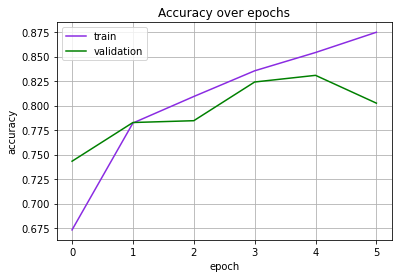

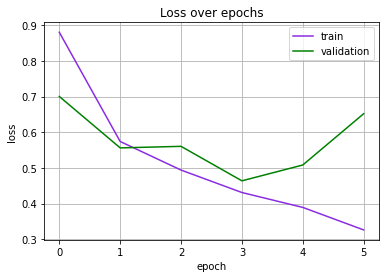

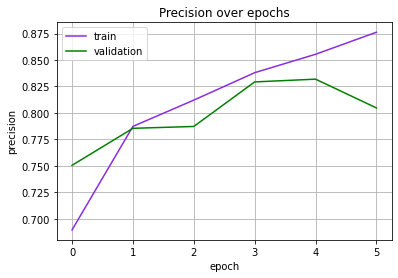

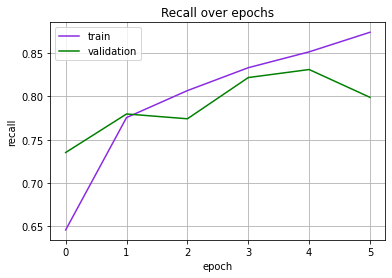

In [9]:
log_data = pd.read_csv(os.path.join(WASSEM_MODEL_LOGS_PATH, f"{MODEL_FILE_NAME}.log"), sep=",", engine="python")
display_train_report_and_f1_score(log_data)
plot_train_data(log_data, train_metric="accuracy", validation_metric="val_accuracy")
plot_train_data(log_data, train_metric="loss", validation_metric="val_loss")
plot_train_data(log_data, train_metric="precision", validation_metric="val_precision")
plot_train_data(log_data, train_metric="recall", validation_metric="val_recall")
plt.show()

In [10]:
predictions = model.predict(test_data)

for prediction in predictions:
    for index, pred_class in enumerate(prediction):
        if pred_class == max(prediction):
            prediction[index] = 1
        else:
            prediction[index] = 0

print(predictions)
print(test_labels)
print(len(predictions), len(test_labels))
print(type(test_labels), type(predictions))

print(f"\n{classification_report(test_labels, predictions)}")

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1621 1621
<class 'numpy.ndarray'> <class 'numpy.ndarray'>

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1090
           1       0.73      0.79      0.76       180
           2       0.76      0.64      0.70       351

   micro avg       0.83      0.83      0.83      1621
   macro avg       0.78      0.78      0.78      1621
weighted avg       0.82      0.83      0.82      1621
 samples avg       0.83      0.83      0.83      1621

